In [3]:
import os

os.chdir(r"C:\Users\adema\VS Code\Projet radiothérapie\projet_S7_radio")

In [4]:
from ApplicationsUNet.loadData import ThoraxDataLoader
import SimpleITK 
import skimage.io as io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import torch.nn.functional as F

import tensorflow as tf
from tensorflow.keras import layers, Model

from matplotlib import cm
from matplotlib.colors import ListedColormap

In [5]:
loader = ThoraxDataLoader("./Data/Data_Medical/MCsimulations")
LS_dataset = loader.load_all_samples("LS")
CT_dataset = loader.load_all_samples("CT")
y_dataset = loader.load_all_samples("HS")
newcmp = loader.newcmp

sample_0001 chargé avec succès.
sample_0002 chargé avec succès.
sample_0003 chargé avec succès.
sample_0004 chargé avec succès.
sample_0005 chargé avec succès.
sample_0006 chargé avec succès.
sample_0007 chargé avec succès.
sample_0008 chargé avec succès.
sample_0009 chargé avec succès.
sample_0010 chargé avec succès.
sample_0011 chargé avec succès.
sample_0012 chargé avec succès.
sample_0013 chargé avec succès.
sample_0014 chargé avec succès.
sample_0015 chargé avec succès.
sample_0016 chargé avec succès.
sample_0017 chargé avec succès.
sample_0018 chargé avec succès.
sample_0019 chargé avec succès.
sample_0020 chargé avec succès.
sample_0021 chargé avec succès.
sample_0022 chargé avec succès.
sample_0023 chargé avec succès.
sample_0024 chargé avec succès.
sample_0025 chargé avec succès.
sample_0026 chargé avec succès.
sample_0027 chargé avec succès.
sample_0028 chargé avec succès.
sample_0029 chargé avec succès.
sample_0030 chargé avec succès.
sample_0031 chargé avec succès.
sample_0

In [6]:
LS_dataset.shape, CT_dataset.shape, y_dataset.shape

((6560, 64, 64, 3), (6560, 64, 64), (6560, 64, 64, 3))

In [13]:
def rgb_to_grayscale(batch):
    r, g, b = batch[:, :, :, 0], batch[:, :, :, 1], batch[:, :, :, 2]
    return 0.2989 * r + 0.5870 * g + 0.1140 * b  # Retourne [B, H, W]

LS_dataset_gray = rgb_to_grayscale(LS_dataset)
y_dataset_gray = rgb_to_grayscale(y_dataset)

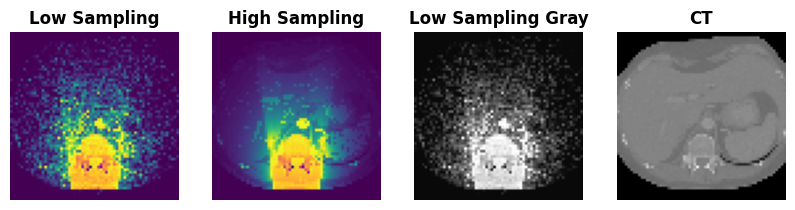

In [42]:
newcmp = loader.newcmp

LS = LS_dataset[0,:,:,:]
LS_gray = LS_dataset_gray[0,:,:]
CT = CT_dataset[0,:,:]
HS = y_dataset[0,:,:,:]

fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(LS, interpolation=None)
axes[0].set_title('Low Sampling',fontweight='bold')
axes[0].axis('off')

axes[1].imshow(HS, interpolation=None)
axes[1].set_title('High Sampling',fontweight='bold')
axes[1].axis('off')

axes[2].imshow(LS_gray, interpolation=None, cmap='gray')
axes[2].set_title('Low Sampling Gray',fontweight='bold')
axes[2].axis('off')

axes[3].imshow(CT, interpolation=None, cmap='gray')
axes[3].set_title('CT',fontweight='bold')
axes[3].axis('off')

plt.show()

# UNet Model with PyTorch

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(2, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    def conv_block(self, in_channels, out_channels):
        """Bloc de convolution : Conv2D -> ReLU -> Conv2D -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = F.max_pool2d(c1, kernel_size=2, stride=2)
        
        c2 = self.enc2(p1)
        p2 = F.max_pool2d(c2, kernel_size=2, stride=2)
        
        c3 = self.enc3(p2)
        p3 = F.max_pool2d(c3, kernel_size=2, stride=2)
        
        c4 = self.enc4(p3)
        p4 = F.max_pool2d(c4, kernel_size=2, stride=2)
        
        # Bottleneck
        bn = self.bottleneck(p4)
        
        # Decoder
        u4 = self.upconv4(bn)
        u4 = torch.cat((u4, c4), dim=1)  # Skip connection
        c5 = self.dec4(u4)
        
        u3 = self.upconv3(c5)
        u3 = torch.cat((u3, c3), dim=1)  # Skip connection
        c6 = self.dec3(u3)
        
        u2 = self.upconv2(c6)
        u2 = torch.cat((u2, c2), dim=1)  # Skip connection
        c7 = self.dec2(u2)
        
        u1 = self.upconv1(c7)
        u1 = torch.cat((u1, c1), dim=1)  # Skip connection
        c8 = self.dec1(u1)
        
        # Output
        outputs = torch.sigmoid(self.output_conv(c8))  # Sigmoid pour ramener entre [0, 1]
        return outputs

In [22]:
unettest = UNet()
batch_size = 5
summary(unettest, input_size=(2, 64, 64), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 64, 64, 64]           1,216
              ReLU-2            [5, 64, 64, 64]               0
            Conv2d-3            [5, 64, 64, 64]          36,928
              ReLU-4            [5, 64, 64, 64]               0
            Conv2d-5           [5, 128, 32, 32]          73,856
              ReLU-6           [5, 128, 32, 32]               0
            Conv2d-7           [5, 128, 32, 32]         147,584
              ReLU-8           [5, 128, 32, 32]               0
            Conv2d-9           [5, 256, 16, 16]         295,168
             ReLU-10           [5, 256, 16, 16]               0
           Conv2d-11           [5, 256, 16, 16]         590,080
             ReLU-12           [5, 256, 16, 16]               0
           Conv2d-13             [5, 512, 8, 8]       1,180,160
             ReLU-14             [5, 51

In [35]:
LS_train = torch.tensor(LS_dataset_gray[:90,:,:], dtype=torch.float32).unsqueeze(1)
CT_train = torch.tensor(CT_dataset[:90,:,:], dtype=torch.float32).unsqueeze(1)
x_train = torch.cat((LS_train, CT_train), dim=1)
y_train = torch.tensor(y_dataset_gray[:90,:,:], dtype=torch.float32).unsqueeze(1)

LS_val = torch.tensor(LS_dataset_gray[90:100,:,:], dtype=torch.float32).unsqueeze(1)
CT_val = torch.tensor(CT_dataset[90:100,:,:], dtype=torch.float32).unsqueeze(1)
x_val = torch.cat((LS_val, CT_val), dim=1)
y_val = torch.tensor(y_dataset_gray[90:100,:,:],  dtype=torch.float32).unsqueeze(1)

LS_test = torch.tensor(LS_dataset_gray[100:120,:,:], dtype=torch.float32).unsqueeze(1)
CT_test = torch.tensor(CT_dataset[100:120,:,:], dtype=torch.float32).unsqueeze(1)
x_test = torch.cat((LS_test, CT_test), dim=1)
y_test = torch.tensor(y_dataset_gray[100:120,:,:], dtype=torch.float32).unsqueeze(1)

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

(torch.Size([90, 2, 64, 64]),
 torch.Size([90, 1, 64, 64]),
 torch.Size([10, 2, 64, 64]),
 torch.Size([10, 1, 64, 64]),
 torch.Size([20, 2, 64, 64]),
 torch.Size([20, 1, 64, 64]))

In [30]:
batch_size = 10

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [31]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Met le modèle en mode évaluation (désactive le dropout, etc.)
    val_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Pas besoin de calculer les gradients pendant l'évaluation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Passage dans le modèle
            outputs = model(inputs)
            
            # Calcul de la perte
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            # Collecter les prédictions et les vraies étiquettes
            preds = outputs.argmax(dim=1)  # Utilisez `argmax` si c'est une tâche de classification multi-classe
            all_preds.extend(preds.cpu().numpy())  # Déplacer les prédictions vers le CPU et les collecter
            all_targets.extend(targets.cpu().numpy())  # Idem pour les cibles
            
    # Calcul de la perte moyenne de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

criterion = nn.MSELoss()  # Loss pour le débruitage
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)  # Déplacer vers GPU si disponible

        # Initialiser les gradients
        optimizer.zero_grad()

        # Passer les données dans le modèle
        outputs = model(inputs)

        # Calculer la perte
        loss = criterion(outputs, targets)

        # Rétropropagation
        loss.backward()

        # Mise à jour des poids
        optimizer.step()

        # Accumuler la perte
        running_loss += loss.item()

        # Afficher la perte
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss:.4f}")
    
    # Évaluation sur le jeu de validation
    evaluate_model(model, val_loader, criterion, device)

    # Vous pouvez ajouter des fonctions d'évaluation ici (sur un jeu de validation, par exemple)

torch.save(model.state_dict(), r"ApplicationsUNet\UNet LS+CT-HS\models\UNet.pth")
print("Entraînement terminé")

Epoch [1/5], Batch [1/9], Loss: 0.0986
Epoch [1/5], Batch [2/9], Loss: 0.0958
Epoch [1/5], Batch [3/9], Loss: 0.0867
Epoch [1/5], Batch [4/9], Loss: 0.0737
Epoch [1/5], Batch [5/9], Loss: 0.0643
Epoch [1/5], Batch [6/9], Loss: 0.0573
Epoch [1/5], Batch [7/9], Loss: 0.0506
Epoch [1/5], Batch [8/9], Loss: 0.0427
Epoch [1/5], Batch [9/9], Loss: 0.0333
Validation Loss: 0.0270
Epoch [2/5], Batch [1/9], Loss: 0.0252
Epoch [2/5], Batch [2/9], Loss: 0.0206
Epoch [2/5], Batch [3/9], Loss: 0.0172
Epoch [2/5], Batch [4/9], Loss: 0.0142
Epoch [2/5], Batch [5/9], Loss: 0.0153
Epoch [2/5], Batch [6/9], Loss: 0.0145
Epoch [2/5], Batch [7/9], Loss: 0.0157
Epoch [2/5], Batch [8/9], Loss: 0.0164
Epoch [2/5], Batch [9/9], Loss: 0.0157
Validation Loss: 0.0153
Epoch [3/5], Batch [1/9], Loss: 0.0161
Epoch [3/5], Batch [2/9], Loss: 0.0143
Epoch [3/5], Batch [3/9], Loss: 0.0373
Epoch [3/5], Batch [4/9], Loss: 0.0208
Epoch [3/5], Batch [5/9], Loss: 0.0224
Epoch [3/5], Batch [6/9], Loss: 0.0168
Epoch [3/5], Bat

In [33]:
def calculate_psnr(original, reconstructed, data_range=1.0):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return np.inf
    psnr = 10*np.log10(data_range**2 / mse)
    return psnr

Mean PSNR: 23.06 dB


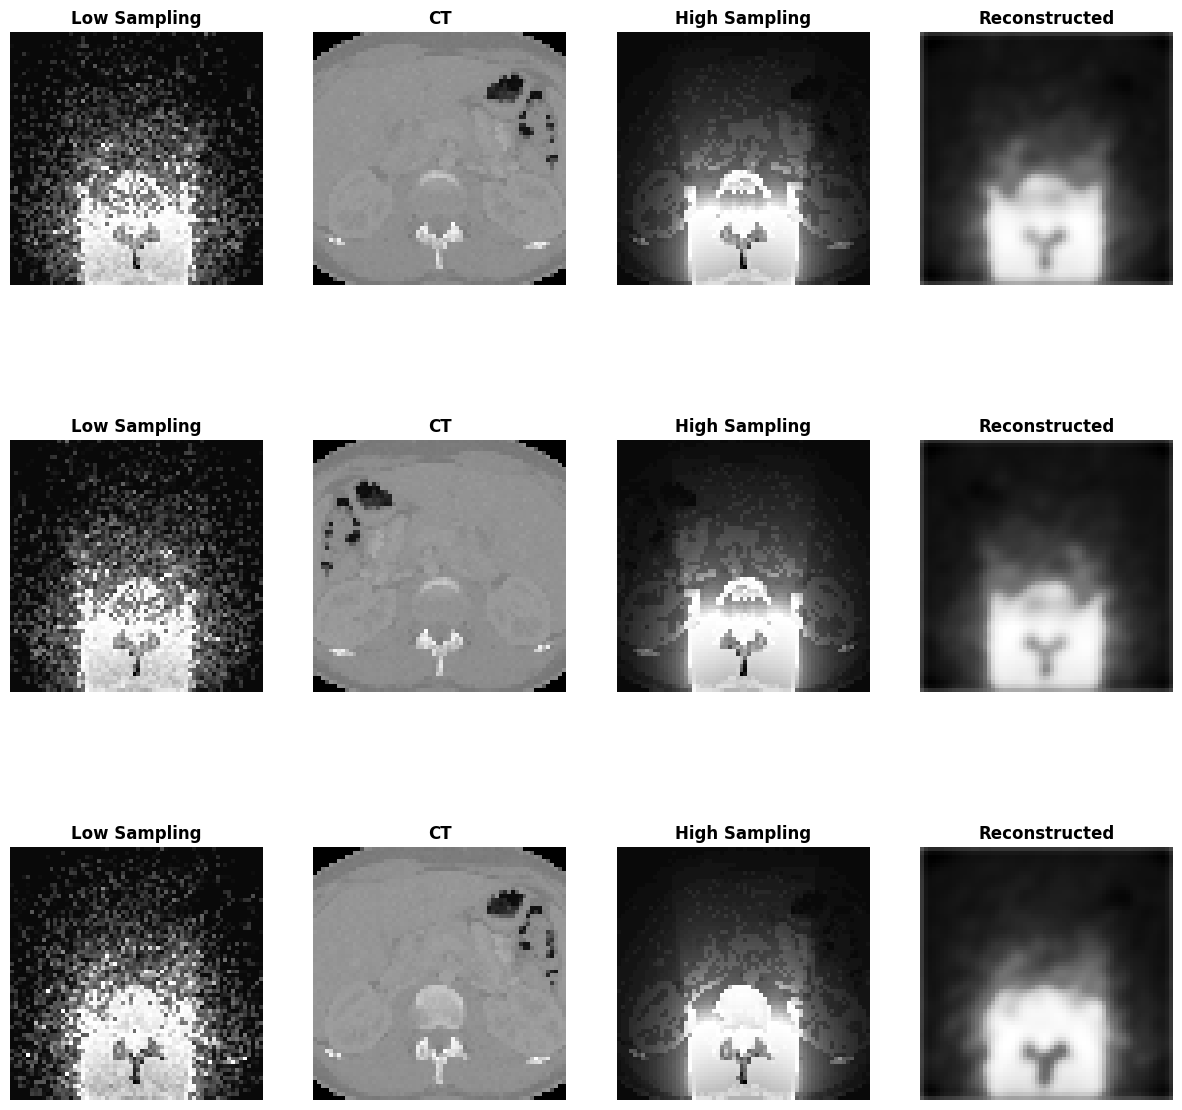

In [45]:
model.eval()

with torch.no_grad():
    y_pred = model(x_test).cpu()

y_pred2 = y_pred.squeeze(1).numpy()
y_test2 = y_test.squeeze(1).numpy()

fig, axes = plt.subplots(3, 4, figsize=(15, 15))

for i in range(3):
    axes[i, 0].imshow(x_test[i, 0], cmap='gray')
    axes[i, 0].set_title('Low Sampling', fontweight='bold')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(x_test[i, 1], cmap='gray')
    axes[i, 1].set_title('CT', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_test2[i], cmap='gray')
    axes[i, 2].set_title('High Sampling', fontweight='bold')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(y_pred2[i], cmap='gray')
    axes[i, 3].set_title('Reconstructed', fontweight='bold')
    axes[i, 3].axis('off')

mean_psnr = np.mean([calculate_psnr(y_test2[i], y_pred2[i]) for i in range(len(y_test2))])
print(f"Mean PSNR: {mean_psnr:.2f} dB")